# Imports

In [2]:
# Basics 
import numpy as np
import sys
import pickle
import os

# plotting 
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
%matplotlib inline 
from IPython.display import Image,display
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
import matplotlib.image as mpimg
import matplotlib.patches as patches
from matplotlib.colors import LinearSegmentedColormap

# Scipy 
import scipy 
import scipy.stats
from scipy.optimize import minimize
from scipy.stats import truncnorm
from scipy.optimize import linprog
from scipy.io import loadmat


In [34]:
# my code 
sys.path.append('./')
sys.path.append('../shared')
sys.path.append('../plotting')

from plotting_basics import plot_q_or_pi,embellish_plot
from plotting_oneD import plot_1D_arrows, plot_1D_values_policy_distortions
from scenarios import setup_params, Agent
from distorted_probabilities import create_distorted_probability_matrix
from matpy_conversions import convert_SI_function
from shared import induce_P
from pCVaR_Shared import apply_pCVaR_operator, distorted_exp

# Loading Data

## Loading Matlab Data for MDP

In [8]:
mat = loadmat('../simulation_results/1D_optimal_policy.mat')

In [9]:
# get MDP parameters 
Ny = mat['Y_set_all'].shape[1]
Ns = mat['Y_set_all'].shape[0] # could subtract one here 
Na = 3
gamma = mat['dis'][0][0]
y_set = mat['Y_set_all'][0,:]
P = mat['P']
r = mat['r']
r_fun = mat['r'][:,0]
gamma = mat['dis']

## Loading Policy Evaluation for Optimal Policy

In [10]:
fname = '../simulation_results/1D_optimal_policy_pCVaR_policy_eval.npz'
fname

'../simulation_results/1D_optimal_policy_pCVaR_policy_eval.npz'

In [11]:
# Load 
container = np.load(fname)
data = [container[key] for key in container]
V = data[0]
Xi = data[1]
Pol_mat = data[3]

## Setup Agent

In [12]:
p,maze = setup_params(4) 
agent = Agent({'num_states':Ns-1,'num_actions':Na,'start_states':[4],'r_params':p['r_params']},maze)

# Further Processing

## Policy in Correct Format

In [13]:
# convert policy to right format 
Pol = np.zeros((Ns,Ny,3))
for x in range(Ns):
    for y in range(Ny):
        Pol[x,y,Pol_mat[x,y]-1]=1
        
Pol.shape
print(Pol[:,3,:])
#print(Pol[:,20,:])

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]]


## Policy Induced Transition Matrix P(x'|x,y)

In [14]:
# creating transition probability matrix induced by optimal policy 
P_ssy= induce_P(P,Pol,Ny,Ns,
                 None,fixed_y=False,
                 pol_type='stochastic',Na=3) # XXXX This line changes to Pol
print(P_ssy.shape)
np.round(P_ssy[:,:,3],2)
np.round(P_ssy[:,:,5],2)

(10, 10, 6)


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  ],
       [0.05, 0.9 , 0.05, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.9 , 0.06, 0.04, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.9 , 0.06, 0.04, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.9 , 0.06, 0.04, 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.04, 0.06, 0.9 , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.04, 0.06, 0.9 , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.05, 0.9 , 0.05, 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.9 , 0.1 , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  ]])

## Convert some stuff for Plotting

In [15]:
V_py = convert_SI_function(V,agent,neg_term_states=[],num_inter_points=Ny)
V_py.shape

(9, 6)

## Effective Policy

In [16]:
Pol_effective = np.zeros_like(Pol) # this is going to be where you end up in X effectively. 
for s in range(Ns-1):
    for y in range(Ny):
        if s==0:
            Pol_effective[s,y,:] = [0,0,1]
        elif s==Ns-2:
            Pol_effective[s,y,:] = [P_ssy[s,s,y],P_ssy[s,s,y],P_ssy[s,s-1,y]]
        else:
            Pol_effective[s,y,:] = [P_ssy[s,s,y],P_ssy[s,s+1,y],P_ssy[s,s-1,y]]

In [17]:
Pol[:,1,:]

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.]])

In [18]:
Pol_effective[:,1,:]


array([[0.  , 0.  , 1.  ],
       [0.06, 0.9 , 0.04],
       [0.06, 0.9 , 0.04],
       [0.06, 0.9 , 0.04],
       [0.06, 0.9 , 0.04],
       [0.06, 0.9 , 0.04],
       [0.06, 0.9 , 0.04],
       [0.9 , 0.05, 0.05],
       [0.1 , 0.1 , 0.9 ],
       [0.  , 0.  , 0.  ]])

In [19]:
print(P_ssy.shape)
print(Pol.shape)

(10, 10, 6)
(10, 6, 3)


## Transition Matrix P(x', y'|x,y)*Xi(x'|x,y)  
- for a particular set of ys; total yet now

In [20]:
(P_xy_xpyp,P_xy_xpyp_alpha,Xi_xy_xpyp) = create_distorted_probability_matrix(P_ssy, #
                                        Xi, # same size as P_ssy
                                        Ns,Ny,Na,
                                        y_set,
                                        yis = [5,4,3,2,1,0],# which y values do you want for plotting
                                        )

## Adjusting far right state alpha=0

In [21]:
Pol_effective[8,0,:]=[0.95, 0.05, 0.05]
Pol_effective[:,0,:]

array([[0.  , 0.  , 1.  ],
       [0.9 , 0.05, 0.05],
       [0.9 , 0.05, 0.05],
       [0.9 , 0.05, 0.05],
       [0.9 , 0.05, 0.05],
       [0.9 , 0.05, 0.05],
       [0.9 , 0.05, 0.05],
       [0.9 , 0.05, 0.05],
       [0.95, 0.05, 0.05],
       [0.  , 0.  , 0.  ]])

# Plotting

In [22]:
# set the bottom row 
Pol_effective[:,0,:]=1/3

In [23]:
Pol_effective[:,0,:]

array([[0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333]])

/kyb/agpd/cgagne/cvar_jmathpsych_2021/policy_optimization/../plotting/plotting_basics.py:430: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


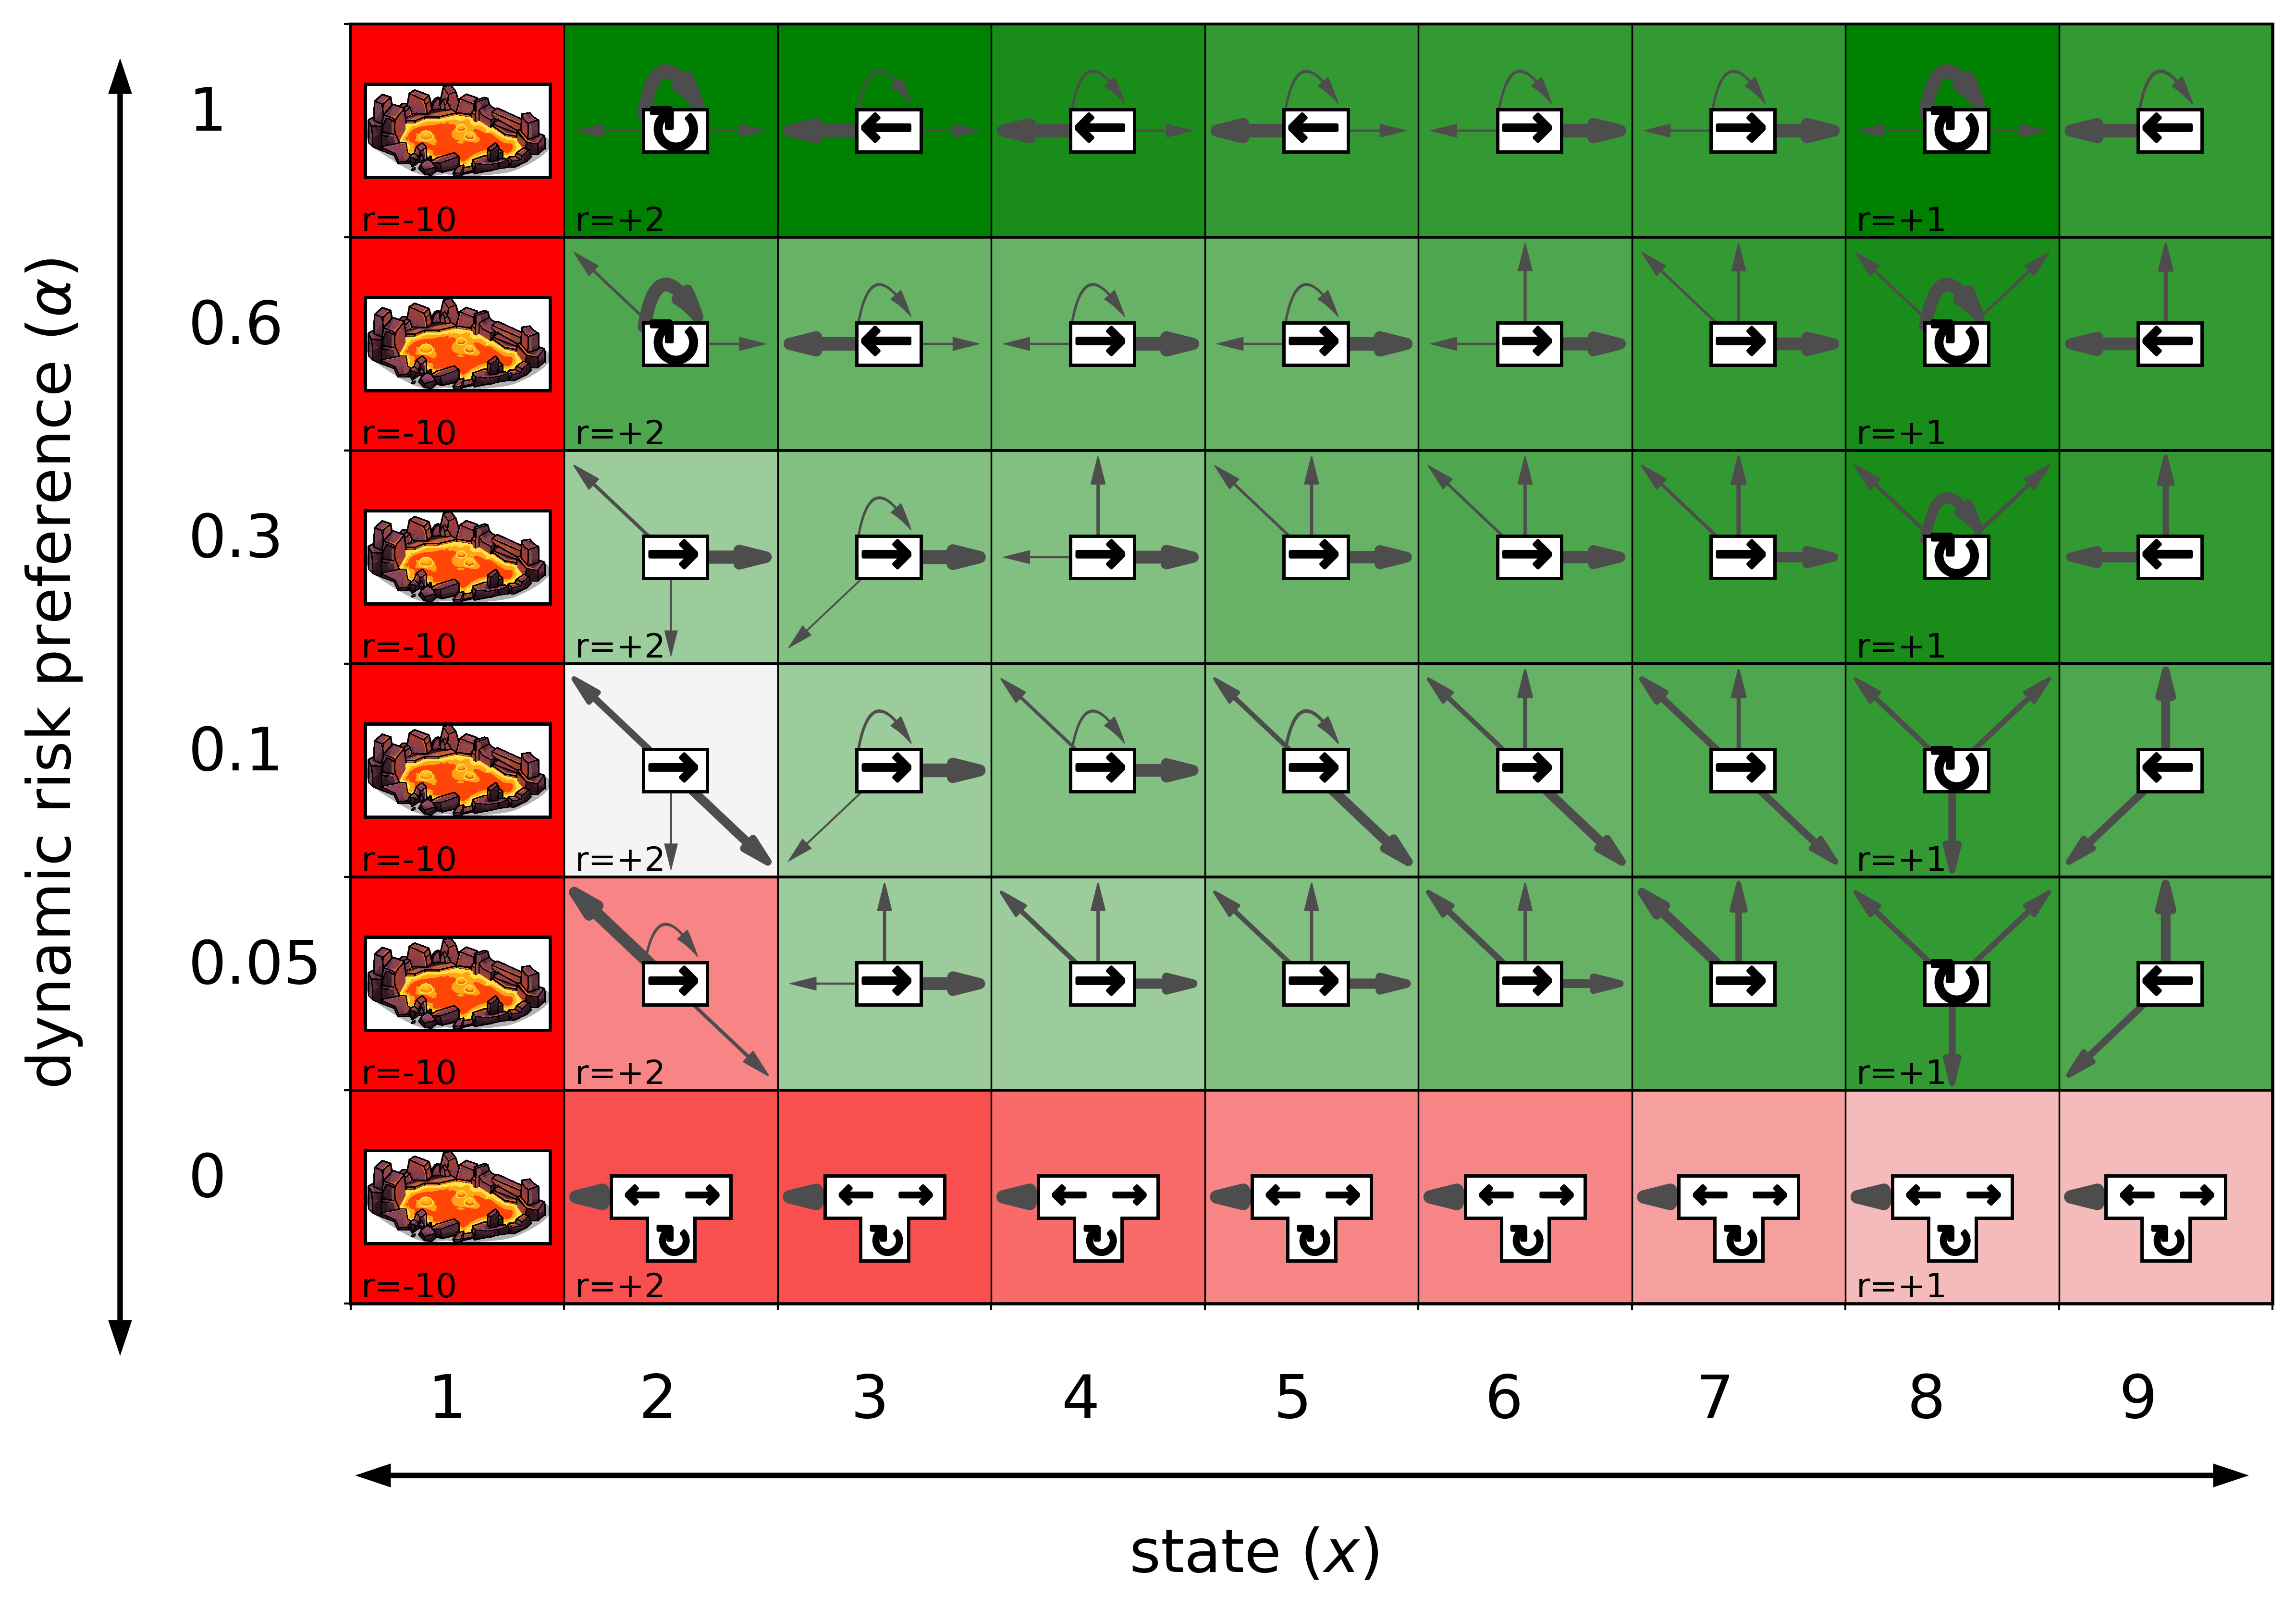

In [24]:
plot_1D_values_policy_distortions(Pol_effective,
                                  V_py,
                                  agent,
                                  np.round(P_xy_xpyp_alpha,2),
                                  np.round(Xi_xy_xpyp,2),
                                  static_or_dynamic='dynamic',
                                  eval_or_opt ='opt',
                                  y_set = [0,0.05,0.1,0.3,0.6,1],
                                  yis = [5,4,3,2,1,0],
                                  Qrange = [-10,10],
                                  term_states_for_plotting = [0,9],
                                  example_start=None,
                                  no_vert_space=True)

# Inspecting the distortion weights

In [27]:
state = 3 -1
alpha_level = 4 # 0=neutral, 5=worst-case

In [28]:
np.round(P_xy_xpyp[state,alpha_level,:,:].T,2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.06, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.04, 0.  , 0.9 , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]])

In [29]:
np.round(Xi_xy_xpyp[state,alpha_level,:,:].T,2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 2.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.93, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]])

In [30]:
np.round((Xi_xy_xpyp[state,alpha_level,:,:]*P_xy_xpyp[state,alpha_level,:,:]).T,2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.12, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.04, 0.  , 0.84, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]])

In [31]:
np.round(-1*V_py[:,::-1].T,1)

array([[-10. ,  10.3,   9.1,   8.1,   7.2,   7.2,   8.1,   9.1,   8.1],
       [-10. ,   6.5,   5.8,   5.4,   6. ,   6.8,   7.7,   8.8,   7.8],
       [-10. ,   4.1,   4.4,   5. ,   5.6,   6.4,   7.3,   8.4,   7.4],
       [-10. ,   0.1,   3.8,   4.4,   5. ,   5.8,   6.7,   8. ,   7. ],
       [-10. ,  -5. ,   3.4,   4.2,   4.8,   5.5,   6.4,   7.8,   6.8],
       [-10. ,  -7. ,  -6.3,  -5.7,  -5.1,  -4.6,  -4.1,  -2.7,  -2.4]])

In [32]:
# manually calculate weights for a particular state and risk preference 
x = state
yi = 5 - alpha_level # for alpha=0.05
V_old = V.copy() # 10 states intead of 9 

(v_est,xis,success,xps) = apply_pCVaR_operator(x,
                                              yi,
                                              V_old,
                                              P_ssy,
                                              0.9,
                                              np.array([0.  , 0.05, 0.1 , 0.3 , 0.6 , 1.  ]),
                                              r,
                                              multi_starts=10,
                                              same_answer_ns=3)
print(v_est)
print(np.round(xis,2))
print(success)
print(xps)

[-3.39977797 -3.39977797 -3.39977797]
[1.   2.   0.93]
True
[1 2 3]


In [35]:
# check the inner function 
p = P_ssy[x,xps,yi]
y = y_set[yi]
dis_exp = distorted_exp(xis,V_old,xps,p,y,y_set,verbose=True)
print(gamma[0][0]*dis_exp)

next states=[1 2 3]
weights=[1.    1.999 0.933]
probs=[0.04 0.06 0.9 ]
weights*probs=[0.04 0.12 0.84]
adjusted alpha=[0.05  0.1   0.047]
interpolated value (undiscounted)=[-5.044  7.533  3.919]
interpolated value x prob (undiscounted)=[-0.202  0.452  3.527]
3.3997779726422896


In [36]:
# apply a different set of distortion weights 
p = P_ssy[x,xps,yi]
y = y_set[yi]
xis_alt = np.array([2, 1,0.93])
dis_exp = distorted_exp(xis_alt,V_old,xps,p,y,y_set,verbose=True)
print(gamma[0][0]*dis_exp)

next states=[1 2 3]
weights=[2.   1.   0.93]
probs=[0.04 0.06 0.9 ]
weights*probs=[0.08  0.06  0.837]
adjusted alpha=[0.1   0.05  0.047]
interpolated value (undiscounted)=[0.173 3.399 3.905]
interpolated value x prob (undiscounted)=[0.007 0.204 3.515]
3.3529257746940297


# Color bar

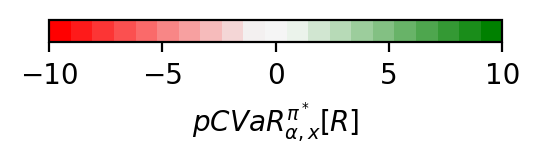

In [37]:
fig = plt.figure(figsize=(8,1),dpi=200)
ax = plt.gca()

# random policy
Pol_py = np.zeros((9,21,3))
Pol_py[:,:,1:3]=0.5

term_states_for_plotting=[0]

Qrange = [-10,10]

for t in term_states_for_plotting:
    Pol_py[t,:]=0
    
# Value Underlay 
v = -1*V[0:9,0].reshape(maze.shape,order='C')
_,im_value = plot_q_or_pi(np.zeros_like(Pol_py),v,'',ax,agent.maze,q_or_pi='q',
            roundoff=1,inc_triangles=False,tri_add_labels=False,annot_value=False,Qrange=Qrange,
             term_states_for_plotting=term_states_for_plotting,colorbar=True)
plt.gca().set_visible(False)
plt.colorbar(im_value,label=r'$pCVaR^{\pi^*}_{\alpha,x}[R]$',orientation="horizontal")